# Solving the Black–Scholes PDE with PINNs

This script demonstrates how to solve the Black–Scholes partial differential equation (PDE)
for a European call option using a Physics–Informed Neural Network (PINN).

The Black–Scholes PDE is given by:

$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0,
$

with terminal condition at maturity \(t=T\):

$V(S,T) = \max(S-K, 0).$

and boundary conditions:

- At $S=0: V(0,t)=0$,
- At $S=S_{\text{max}}: V(S_{\text{max}},t)= S_{\text{max}}-K\exp(-r(T-t))$.

We will:
- Define a feed-forward neural network in PyTorch that approximates \(V(S,t)\).
- Use automatic differentiation to compute the necessary derivatives.
- Define a loss function that enforces the PDE residual and the boundary/terminal conditions.
- Train the network and finally compare the learned solution (at \(t=0\)) to the analytical Black–Scholes formula.


In [1]:
# %%
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cpu



## Black–Scholes Parameters and Domain Setup

We set the parameters for the Black–Scholes model and define our spatial and temporal domains.


In [2]:
# Black-Scholes parameters
r = 0.05        # risk-free interest rate
sigma = 0.2     # volatility
K = 50.0        # strike price
T = 1.0         # maturity time
S_max = 100.0   # maximum asset price in our domain


## Defining the PINN Architecture

We use a fully connected neural network with three hidden layers and tanh activations.
The network takes as input the asset price \(S\) and time \(t\) and outputs the approximated option price \(V(S,t)\).

In [3]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x):
        # x is a tensor of shape (N,2) with columns [S, t]
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Define network architecture: input size 2, three hidden layers (50 neurons each), output size 1
layers = [2, 50, 50, 50, 1]
model = PINN(layers).to(device)


## Computing the PDE Residual

Using PyTorch's automatic differentiation, we compute the necessary derivatives of \(V(S,t)\)
with respect to \(S\) and \(t\) to form the residual of the Black–Scholes PDE.

In [4]:
def pde_residual(model, S, t):
    # Ensure S and t require gradients for autograd
    S.requires_grad_(True)
    t.requires_grad_(True)
    
    X = torch.cat([S, t], dim=1)  # shape: (N,2)
    u = model(X)
    
    # First derivative with respect to t
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                              create_graph=True, retain_graph=True)[0]
    # First derivative with respect to S
    u_S = torch.autograd.grad(u, S, grad_outputs=torch.ones_like(u), 
                              create_graph=True, retain_graph=True)[0]
    # Second derivative with respect to S
    u_SS = torch.autograd.grad(u_S, S, grad_outputs=torch.ones_like(u_S), 
                               create_graph=True, retain_graph=True)[0]
    
    # Black–Scholes PDE residual:
    # u_t + 0.5 * sigma^2 * S^2 * u_SS + r * S * u_S - r * u = 0
    residual = u_t + 0.5 * sigma**2 * S**2 * u_SS + r * S * u_S - r * u
    return residual

## Sampling Points in the Domain

We sample points for the interior collocation (to enforce the PDE), and for the boundaries and terminal condition.

- **Interior points**: $S \in (0, S_{{max}})$ and $t \in (0, T)$.
- **Boundary at $S=0$**: $V(0,t)=0$.
- **Terminal condition at $t=T$**: $V(S,T)=\max(S-K,0)$.
- **Boundary at $S=S_{max}$**: $V(S_{max},t)=S_{\text{max}}-K\exp(-r(T-t))$.

In [5]:
def sampler(n_interior, n_bc, n_terminal, n_bc_Smax):
    # Interior collocation points (for PDE residual)
    S_colloc = torch.rand((n_interior, 1), device=device) * S_max
    t_colloc = torch.rand((n_interior, 1), device=device) * T
    
    # Boundary condition at S=0: V(0,t)=0
    S_bc = torch.zeros((n_bc, 1), device=device)
    t_bc = torch.rand((n_bc, 1), device=device) * T
    
    # Terminal condition at t=T: V(S,T)=max(S-K,0)
    S_terminal = torch.rand((n_terminal, 1), device=device) * S_max
    t_terminal = T * torch.ones((n_terminal, 1), device=device)
    
    # Boundary condition at S=S_max: V(S_max,t)= S_max - K*exp(-r*(T-t))
    S_bc_Smax = S_max * torch.ones((n_bc_Smax, 1), device=device)
    t_bc_Smax = torch.rand((n_bc_Smax, 1), device=device) * T
    
    return (S_colloc, t_colloc), (S_bc, t_bc), (S_terminal, t_terminal), (S_bc_Smax, t_bc_Smax)


## Training the PINN

We define the loss as the sum of:
- **PDE residual loss** (at interior collocation points),
- **Boundary loss** (at $S=0$ and $S=S_{\text{max}})$,
- **Terminal loss** at $t=T$.

Then we train the network using the Adam optimizer.

In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10000

# Number of points for each region
n_interior = 1000
n_bc = 200
n_terminal = 200
n_bc_Smax = 200

for epoch in range(num_epochs):
    model.train()
    
    # Sample points
    (S_colloc, t_colloc), (S_bc, t_bc), (S_terminal, t_terminal), (S_bc_Smax, t_bc_Smax) = sampler(n_interior, n_bc, n_terminal, n_bc_Smax)
    
    optimizer.zero_grad()
    
    # PDE residual loss
    residual = pde_residual(model, S_colloc, t_colloc)
    mse_pde = torch.mean(residual**2)
    
    # Boundary condition at S=0: V(0,t)=0
    X_bc = torch.cat([S_bc, t_bc], dim=1)
    u_bc = model(X_bc)
    mse_bc = torch.mean(u_bc**2)
    
    # Terminal condition at t=T: V(S,T)=max(S-K,0)
    X_terminal = torch.cat([S_terminal, t_terminal], dim=1)
    u_terminal = model(X_terminal)
    target_terminal = torch.maximum(S_terminal - K, torch.zeros_like(S_terminal))
    mse_terminal = torch.mean((u_terminal - target_terminal)**2)
    
    # Boundary condition at S=S_max: V(S_max,t)= S_max - K*exp(-r*(T-t))
    X_bc_Smax = torch.cat([S_bc_Smax, t_bc_Smax], dim=1)
    u_bc_Smax = model(X_bc_Smax)
    target_bc_Smax = S_max - K * torch.exp(-r*(T - t_bc_Smax))    
    mse_bc_Smax = torch.mean((u_bc_Smax - target_bc_Smax)**2)
    
    loss = mse_pde + mse_bc + mse_terminal + mse_bc_Smax
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Total Loss: {loss.item():.6e} | PDE: {mse_pde.item():.6e} | BC0: {mse_bc.item():.6e} | Terminal: {mse_terminal.item():.6e} | BC_Smax: {mse_bc_Smax.item():.6e}")

    


Epoch     0 | Total Loss: 2.944416e+03 | PDE: 2.553332e-04 | BC0: 6.549627e-03 | Terminal: 3.461886e+02 | BC_Smax: 2.598221e+03
Epoch  1000 | Total Loss: 1.233467e+02 | PDE: 5.889376e+00 | BC0: 3.404347e-03 | Terminal: 4.607662e+00 | BC_Smax: 1.128463e+02
Epoch  2000 | Total Loss: 1.140382e+01 | PDE: 7.002735e+00 | BC0: 2.896488e-02 | Terminal: 3.582654e+00 | BC_Smax: 7.894699e-01
Epoch  3000 | Total Loss: 3.337752e-01 | PDE: 5.222135e-02 | BC0: 6.953798e-04 | Terminal: 1.924824e-01 | BC_Smax: 8.837602e-02
Epoch  4000 | Total Loss: 1.641952e-01 | PDE: 4.321045e-02 | BC0: 2.785545e-04 | Terminal: 1.019393e-01 | BC_Smax: 1.876695e-02
Epoch  5000 | Total Loss: 1.774257e-01 | PDE: 1.913752e-02 | BC0: 1.357508e-04 | Terminal: 1.022412e-01 | BC_Smax: 5.591115e-02
Epoch  6000 | Total Loss: 1.174349e-01 | PDE: 1.580453e-02 | BC0: 2.432681e-04 | Terminal: 8.904078e-02 | BC_Smax: 1.234628e-02
Epoch  7000 | Total Loss: 4.939253e-02 | PDE: 1.384049e-02 | BC0: 2.597044e-05 | Terminal: 3.505002e-02 

## Evaluating the PINN Solution

After training, we evaluate the network at \(t=0\) (current time) for a range of asset prices \(S\)
and compare it with the analytical Black–Scholes formula for a European call option.

In [7]:
# Generate asset prices for evaluation
S_vals = np.linspace(0, S_max, 200)
t_val = 0.0  # current time
S_tensor = torch.tensor(S_vals.reshape(-1, 1), dtype=torch.float32, device=device)
t_tensor = torch.tensor(t_val * np.ones_like(S_vals).reshape(-1, 1), dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    X_eval = torch.cat([S_tensor, t_tensor], dim=1)
    u_pred = model(X_eval).cpu().numpy().flatten()

## Analytical Black-Scholes Solution and Comparison

We compare the PINN solution with the analytical solution for a European call option.


In [8]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    # At t=0, time to maturity is T.
    # To avoid division by zero for S=0, we use a small epsilon.
    eps = 1e-8
    d1 = (np.log(np.maximum(S, eps)/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    call[S < eps] = 0.0
    return call

u_analytical = black_scholes_call(S_vals, K, T, r, sigma)

### Plotting the Solutions

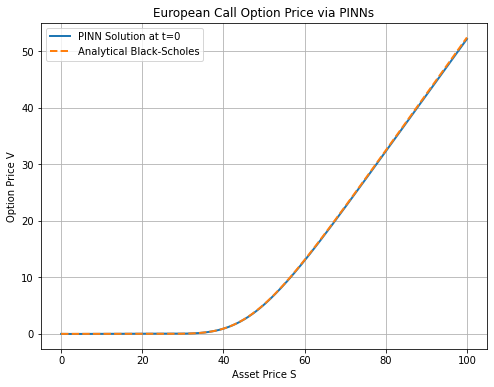

In [9]:

# %%
plt.figure(figsize=(8,6))
plt.plot(S_vals, u_pred, label='PINN Solution at t=0', lw=2)
plt.plot(S_vals, u_analytical, '--', label='Analytical Black-Scholes', lw=2)
plt.xlabel('Asset Price S')
plt.ylabel('Option Price V')
plt.title('European Call Option Price via PINNs')
plt.legend()
plt.grid(True)
plt.show()

### Error Analysis

We plot the absolute error between the PINN solution and the analytical solution.

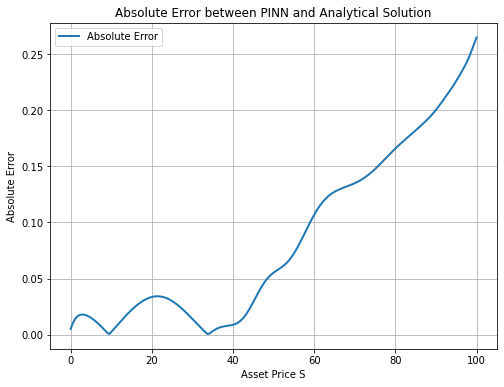

In [10]:
error = np.abs(u_pred - u_analytical)
plt.figure(figsize=(8,6))
plt.plot(S_vals, error, label='Absolute Error', lw=2)
plt.xlabel('Asset Price S')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between PINN and Analytical Solution')
plt.legend()
plt.grid(True)
plt.show()
